In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
import numpy as np

from syft.frameworks.torch.differential_privacy import pate

W0629 18:34:59.660135 140472524900160 secure_random.py:22] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow (1.14.1-dev20190517). Fix this by compiling custom ops.
W0629 18:34:59.687890 140472524900160 deprecation_wrapper.py:119] From /home/ayush/anaconda3/lib/python3.7/site-packages/tf_encrypted/session.py:28: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.MNIST('~/.pytorch/MNIST_data', train=True, download=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data', train=False, download=True, transform=transform)

In [3]:
print(len(trainset))
print(len(testset))

60000
10000


In [4]:
num_teacher = 100
len_teacher_set = len(trainset)//num_teacher

teacher_set = [torch.utils.data.Subset(trainset, list(range(i * len_teacher_set, (i+1) * len_teacher_set))) for i in range(num_teacher)]
student_set = torch.utils.data.Subset(testset, list(range(int(len(testset) * 0.9))))
test_set = torch.utils.data.Subset(testset, list(range(int(len(testset) * 0.9), len(testset))))

print("Number of teachers : ", num_teacher)
print("Length of data in teacher set : ", len_teacher_set)
print("Length of student set : ", len(student_set))
print("Length of test set : ", len(test_set))

Number of teachers :  100
Length of data in teacher set :  600
Length of student set :  9000
Length of test set :  1000


In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.fc2(x))
        
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

teachers = [Model().to(device) for _ in range(num_teacher)]
student = Model().to(device)

In [7]:
teacherloader = [torch.utils.data.DataLoader(data, batch_size=60, shuffle = True, drop_last=True) for data in teacher_set]
teacheroptim = [optim.SGD(teacher.parameters(), lr = 0.01, momentum = 0.5) for teacher in teachers]
criterion = nn.NLLLoss()

In [8]:
for model in teachers:
    model.train()

In [9]:
epochs = 100

teacher_train_history = {'avg_losses':{}, 'avg_accuracies':{}}
for e in range(epochs):
    print("Epoch ", (e+1), " ...")
    
    avgloss = []
    avgacc = []
    
    for i in range(num_teacher):
        counter = 0
        total_loss = 0
        acc_count = 0
        
        model = teachers[i]
        dataloader = teacherloader[i]
        optimizer = teacheroptim[i]
        
        for images, labels in dataloader:
            counter += images.size(0)
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            logps = model(images)
            preds = torch.argmax(torch.exp(logps), dim=1)
            
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * images.size(0)
            acc_count += (preds == labels).sum().item()
        
        avgloss.append(total_loss/counter)
        avgacc.append(acc_count/counter)
    
    print(" Average losses : ", [avgl for avgl in avgloss])
    print(" Average accuracies : ", [avga for avga in avgacc])
    teacher_train_history['avg_losses'][e] = avgloss
    teacher_train_history['avg_accuracies'][e] = avgacc 

Epoch  1  ...


/home/ayush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


 Average losses :  [2.315844440460205, 2.312033748626709, 2.3150478839874267, 2.3141572952270506, 2.3204876661300657, 2.3123465061187742, 2.3108723640441893, 2.308582043647766, 2.296956467628479, 2.3115979194641114, 2.303632640838623, 2.335649085044861, 2.3070606708526613, 2.3125891208648683, 2.294966197013855, 2.312525486946106, 2.2981401920318603, 2.3078195095062255, 2.3018455266952516, 2.312373495101929, 2.31425998210907, 2.31891930103302, 2.3122085332870483, 2.3160569190979006, 2.3123373985290527, 2.2971070289611815, 2.305942702293396, 2.316029763221741, 2.310627269744873, 2.303522300720215, 2.3177813291549683, 2.3134998798370363, 2.3044488430023193, 2.3069618940353394, 2.296596097946167, 2.3172768115997315, 2.308604121208191, 2.322646164894104, 2.3043538331985474, 2.3114593744277956, 2.3126999378204345, 2.3066397190093992, 2.308769130706787, 2.3119250535964966, 2.3125930547714235, 2.3151048183441163, 2.3107552766799926, 2.321124219894409, 2.312565279006958, 2.305430006980896, 2.31

 Average losses :  [2.283892846107483, 2.3052671909332276, 2.2969287872314452, 2.295678734779358, 2.285386657714844, 2.2793702125549316, 2.2947350978851317, 2.2766429662704466, 2.2773794412612913, 2.2892663717269897, 2.2802528381347655, 2.286744570732117, 2.297676348686218, 2.289183807373047, 2.2827763319015504, 2.300605368614197, 2.272797441482544, 2.27054705619812, 2.288601112365723, 2.291328859329224, 2.2938605308532716, 2.3001946210861206, 2.292293667793274, 2.2992516040802, 2.3005972385406492, 2.2822733879089356, 2.292404842376709, 2.288055109977722, 2.2850133895874025, 2.292452597618103, 2.302533173561096, 2.28962082862854, 2.2977320194244384, 2.3031555652618407, 2.2806475162506104, 2.287841725349426, 2.295615005493164, 2.283254933357239, 2.277238869667053, 2.30337917804718, 2.2905382394790648, 2.275368165969849, 2.285010051727295, 2.282805609703064, 2.3008697271347045, 2.2858479261398315, 2.2975355863571165, 2.297730541229248, 2.2958481550216674, 2.2829520225524904, 2.2976802349

 Average losses :  [2.2493761777877808, 2.290332388877869, 2.287581729888916, 2.2746527194976807, 2.2569839477539064, 2.247177743911743, 2.281079649925232, 2.2568997383117675, 2.2546212434768678, 2.271573233604431, 2.250207018852234, 2.2631335496902465, 2.274458718299866, 2.267475986480713, 2.251155209541321, 2.2864357471466064, 2.2525606632232664, 2.2441635370254516, 2.2729913234710692, 2.277720332145691, 2.273281955718994, 2.281433939933777, 2.2756844758987427, 2.2783568143844604, 2.2908662080764772, 2.2399611949920653, 2.269500207901001, 2.2665844917297364, 2.259055185317993, 2.2784696578979493, 2.277913451194763, 2.2792420625686645, 2.2805729627609255, 2.285600519180298, 2.24248046875, 2.267296624183655, 2.2765238285064697, 2.254372477531433, 2.25497362613678, 2.290251111984253, 2.2718751430511475, 2.267320418357849, 2.256237506866455, 2.2702910900115967, 2.2862401962280274, 2.2717533349990844, 2.271902823448181, 2.266688370704651, 2.267403793334961, 2.261050271987915, 2.2741890907

 Average losses :  [2.211713266372681, 2.276357388496399, 2.2576327323913574, 2.2471484422683714, 2.221905994415283, 2.2196455240249633, 2.270515871047974, 2.2002331495285032, 2.2351000547409057, 2.2432205200195314, 2.2056615352630615, 2.226654362678528, 2.24759955406189, 2.2225061655044556, 2.225772523880005, 2.2675325870513916, 2.221932792663574, 2.196328139305115, 2.2399138450622558, 2.2523072719573975, 2.244401454925537, 2.274083209037781, 2.2651417732238768, 2.2571997165679933, 2.2694219589233398, 2.1898751735687254, 2.245354652404785, 2.2173821926116943, 2.222296929359436, 2.2674105405807494, 2.2513454437255858, 2.251617956161499, 2.256882977485657, 2.2862555503845217, 2.173264575004578, 2.231639528274536, 2.252312445640564, 2.2162759780883787, 2.2164904117584228, 2.2813230752944946, 2.2411481142044067, 2.2230047225952148, 2.233414053916931, 2.230087995529175, 2.279850125312805, 2.235092377662659, 2.266880416870117, 2.226455020904541, 2.2302023649215696, 2.2432123184204102, 2.244

 Average losses :  [2.1323901176452638, 2.261331844329834, 2.2259907960891723, 2.1867632627487184, 2.1140254020690916, 2.140490770339966, 2.2375035524368285, 2.107889103889465, 2.1709577322006224, 2.1845849990844726, 2.1088702917099, 2.1351076126098634, 2.2077322244644164, 2.1497471570968627, 2.144230341911316, 2.251279854774475, 2.16168532371521, 2.1069275617599486, 2.2077061891555787, 2.2012211561203, 2.20381441116333, 2.248849558830261, 2.237606906890869, 2.210090661048889, 2.252558875083923, 2.087390732765198, 2.2076550006866453, 2.1536362886428835, 2.1590770959854124, 2.245304250717163, 2.202060580253601, 2.2241563320159914, 2.219398093223572, 2.267719531059265, 2.051716649532318, 2.137035036087036, 2.2177379369735717, 2.1415554523468017, 2.1201512098312376, 2.269729995727539, 2.190391516685486, 2.1403622388839723, 2.161730647087097, 2.193053412437439, 2.246883749961853, 2.178409218788147, 2.2407566785812376, 2.1526406049728393, 2.179081153869629, 2.181776833534241, 2.203547859191

 Average losses :  [1.9967872619628906, 2.233737349510193, 2.1584933757781983, 2.0518136739730837, 1.958560824394226, 2.008841669559479, 2.2040199279785155, 1.9617602705955506, 2.0688911199569704, 2.1055404901504517, 1.9352590084075927, 1.9814394950866698, 2.1199856996536255, 2.0269991636276243, 1.9821687579154967, 2.2162133932113646, 2.041356992721558, 1.9267168521881104, 2.126960563659668, 2.1315857648849486, 2.1382898330688476, 2.204051208496094, 2.1819474697113037, 2.1500993251800535, 2.229203701019287, 1.9376314759254456, 2.1130876779556274, 2.0267072319984436, 2.036905121803284, 2.2051289796829225, 2.1026939392089843, 2.185157895088196, 2.146121454238892, 2.2636222362518312, 1.9064440727233887, 1.9923654794692993, 2.1425209522247313, 2.027035880088806, 1.9931219339370727, 2.246808338165283, 2.091294193267822, 2.008019745349884, 2.0137423992156984, 2.0814523935317992, 2.2139624834060667, 2.0731159806251527, 2.184747004508972, 2.0376981616020204, 2.0668259978294374, 2.0785443186759

 Average losses :  [1.787626314163208, 2.186639904975891, 2.0732623100280763, 1.871711802482605, 1.7475145220756532, 1.7696572184562682, 2.128061842918396, 1.710717785358429, 1.8778284549713136, 1.9868581652641297, 1.6275073170661927, 1.790402901172638, 2.0488243103027344, 1.8796110153198242, 1.7755833268165588, 2.1262876749038697, 1.8640346765518188, 1.6335747480392455, 1.9773589611053466, 1.9619635701179505, 1.9913176774978638, 2.130359721183777, 2.089799332618713, 2.040917420387268, 2.175025796890259, 1.6550405383110047, 1.9926641583442688, 1.8086032390594482, 1.890389323234558, 2.1337469577789308, 1.944803202152252, 2.0856628894805906, 2.020465779304504, 2.2200442790985107, 1.6457987070083617, 1.749410581588745, 1.9870427608489991, 1.8376169085502625, 1.778436827659607, 2.2018009185791017, 1.9048385977745057, 1.7912239670753478, 1.7697752714157104, 1.8925413846969605, 2.1504072666168215, 1.8429353952407836, 2.0833046793937684, 1.8682742834091186, 1.9347247242927552, 1.9132042169570

 Average losses :  [1.5496259927749634, 2.1098001480102537, 1.866990864276886, 1.575856363773346, 1.4902523279190063, 1.5345698714256286, 1.977805233001709, 1.5149852991104127, 1.6210723996162415, 1.7740023851394653, 1.2958480358123778, 1.5278765559196472, 1.8651005625724792, 1.5964736938476562, 1.529914343357086, 1.9519100546836854, 1.6773957371711732, 1.407482624053955, 1.7630385041236878, 1.7478067398071289, 1.7905007600784302, 2.0008973360061644, 1.9069359064102174, 1.8175171732902526, 2.0877479791641234, 1.4347494125366211, 1.7825895190238952, 1.5402183771133422, 1.574579119682312, 2.01935555934906, 1.6437744975090027, 1.910504114627838, 1.8359453678131104, 2.1757634401321413, 1.4266533136367798, 1.413820207118988, 1.7616757988929748, 1.651197862625122, 1.5778954744338989, 2.1321202993392943, 1.6715295433998107, 1.5593612551689149, 1.4577014446258545, 1.6331883549690247, 2.016325283050537, 1.5711089611053466, 1.9188786268234252, 1.6351927042007446, 1.6755837678909302, 1.6403257250

 Average losses :  [1.3356236815452576, 1.9667542934417725, 1.593490445613861, 1.2963529229164124, 1.2812715649604798, 1.3152833104133606, 1.755588126182556, 1.2763630270957946, 1.4404746651649476, 1.5296256422996521, 1.0755977213382721, 1.2909627079963684, 1.6775877594947814, 1.469515323638916, 1.4080841898918153, 1.7319490671157838, 1.3685259819030762, 1.1643789291381836, 1.4712532758712769, 1.5197036743164063, 1.5079520702362061, 1.8126798391342163, 1.6239219069480897, 1.6265451431274414, 1.953980302810669, 1.1455871224403382, 1.5265235662460328, 1.2513786673545837, 1.3745767235755921, 1.8358723044395446, 1.3350507378578187, 1.705844795703888, 1.6287838816642761, 2.073035645484924, 1.1777774393558502, 1.1687294721603394, 1.4559264779090881, 1.439211118221283, 1.3456794619560242, 1.9983126640319824, 1.4055288314819336, 1.271509873867035, 1.1467951595783235, 1.3607114195823669, 1.8480866074562072, 1.2968310832977294, 1.7168042302131652, 1.4385146498680115, 1.4097442030906677, 1.425370

 Average losses :  [1.1017128825187683, 1.7639968752861024, 1.3490189790725708, 1.1110377132892608, 1.1021659791469574, 1.1205141127109528, 1.4902755737304687, 1.1378535270690917, 1.2793227553367614, 1.3271748423576355, 0.9454044163227081, 1.1553439140319823, 1.4513041019439696, 1.2883692502975463, 1.2380910456180572, 1.4822012066841126, 1.1643467187881469, 1.0062368035316467, 1.215478765964508, 1.330739688873291, 1.2495953798294068, 1.609738552570343, 1.4159457087516785, 1.4083093404769897, 1.7489732027053833, 0.9952996611595154, 1.3304771780967712, 1.0856383323669434, 1.1288706183433532, 1.665064525604248, 1.1243055522441865, 1.3643646121025086, 1.3786622524261474, 1.941677749156952, 1.051787507534027, 1.0558835685253143, 1.1811087489128114, 1.3062474370002746, 1.1419272303581238, 1.848937749862671, 1.3195383906364442, 1.1122894287109375, 1.015569031238556, 1.1584151625633239, 1.7189271807670594, 1.177641326189041, 1.5084249258041382, 1.2906277060508728, 1.1691255688667297, 1.2058488

 Average losses :  [0.9899822354316712, 1.5762284874916077, 1.1265162169933318, 1.0081155478954316, 1.005265724658966, 1.0372544407844544, 1.2524189114570619, 0.969500583410263, 1.115234559774399, 1.1134977877140044, 0.7884408593177795, 1.0280033707618714, 1.2417855858802795, 1.1352246463298798, 1.13860924243927, 1.2328239917755126, 1.0495332479476929, 0.852784252166748, 1.0493498384952544, 1.1801318287849427, 1.1256040155887603, 1.4101459980010986, 1.1591540277004242, 1.318958616256714, 1.4931476712226868, 0.9366563141345978, 1.1930814504623413, 0.9643905997276306, 0.9575957179069519, 1.4298385858535767, 0.9710173547267914, 1.2037197828292847, 1.2888124227523803, 1.8134849429130555, 0.9347457647323608, 0.8850126743316651, 0.9909099638462067, 1.184424102306366, 0.9736830413341522, 1.5851902484893798, 1.142359060049057, 1.0273377656936646, 0.8651471436023712, 0.9988308429718018, 1.5174199104309083, 1.007263368368149, 1.341009271144867, 1.0987988531589508, 1.1311701476573943, 1.093367791

 Average losses :  [0.9316926717758178, 1.3624557375907898, 1.0390543639659882, 0.8395742475986481, 0.9017231822013855, 0.982591050863266, 1.1011377453804017, 0.8021814525127411, 1.0330383062362671, 0.9830290496349334, 0.712575900554657, 0.8838150978088379, 1.0962443470954895, 1.0617736995220184, 1.0513479351997375, 1.113678163290024, 0.8934446454048157, 0.8360568404197692, 0.9202713966369629, 1.0665455758571625, 0.9843209683895111, 1.24534729719162, 1.0307287454605103, 1.1109099864959717, 1.3573860049247741, 0.8660591304302215, 1.0640324354171753, 0.8564951121807098, 0.9255383431911468, 1.2496214509010315, 0.8484930038452149, 1.0346493303775788, 1.0675144016742706, 1.6119954228401183, 0.8773887395858765, 0.8201430320739747, 0.8917475819587708, 0.9741273760795593, 0.8584566116333008, 1.3172772884368897, 1.0464390635490417, 0.8883419215679169, 0.7482102274894714, 0.9149022936820984, 1.441047978401184, 0.9141361832618713, 1.165607488155365, 0.9693148255348205, 0.941495132446289, 1.055878

 Average losses :  [0.8187529802322387, 1.270908272266388, 0.8694393277168274, 0.7279527127742768, 0.7403564274311065, 0.8088356852531433, 0.9497593164443969, 0.8279753804206849, 0.9110808551311493, 0.8845187306404114, 0.6586326658725739, 0.8663658022880554, 1.0034679830074311, 0.9588149905204773, 0.9771976053714753, 1.015811663866043, 0.8378906548023224, 0.672115820646286, 0.8131898522377015, 0.9880629062652588, 0.8461645305156708, 1.125696450471878, 0.9119457483291626, 1.0442359387874602, 1.2013936042785645, 0.7503072202205658, 0.9425409018993378, 0.8034466207027435, 0.7474870383739471, 1.1184930801391602, 0.7325534760951996, 0.8999918341636658, 0.9335162401199341, 1.4251346826553344, 0.7926558196544647, 0.7339173793792725, 0.7731415629386902, 0.9232365965843201, 0.7274695694446563, 1.1765825033187867, 0.9105643332004547, 0.8929046571254731, 0.6786692678928375, 0.8260422348976135, 1.2597676515579224, 0.8343945264816284, 0.988063645362854, 0.905879122018814, 0.83234503865242, 0.916191

 Average losses :  [0.7534498155117035, 1.1123821496963502, 0.782610285282135, 0.7107870787382126, 0.7847542107105255, 0.7953588247299195, 0.8627208590507507, 0.6804498314857483, 0.8913968205451965, 0.7808191776275635, 0.580451250076294, 0.8133184611797333, 0.8648890256881714, 0.936765706539154, 0.9725815534591675, 0.879386442899704, 0.802937912940979, 0.687994658946991, 0.759995061159134, 0.8994895339012146, 0.7205466508865357, 1.0595543920993804, 0.8483923435211181, 0.9566367268562317, 1.0525741398334503, 0.7133204638957977, 0.9053411304950714, 0.7494535267353057, 0.7272376447916031, 0.9988772511482239, 0.6758342415094376, 0.8292563676834106, 0.862384581565857, 1.2870437026023864, 0.7444718778133392, 0.6969434320926666, 0.6765743553638458, 0.8912522554397583, 0.6536100775003433, 0.9689390897750855, 0.8222303688526154, 0.8137107193470001, 0.6821893751621246, 0.7214687287807464, 1.218475842475891, 0.6932333469390869, 0.880128824710846, 0.8660646140575409, 0.8188377320766449, 0.82580308

 Average losses :  [0.6871978342533112, 1.0118870735168457, 0.7459925532341003, 0.6434186100959778, 0.6631863743066788, 0.7523590862751007, 0.7790924429893493, 0.6237022340297699, 0.8000539064407348, 0.6943494439125061, 0.5547886490821838, 0.7800976395606994, 0.8167081236839294, 0.8439754903316498, 0.9128741800785065, 0.8895032942295075, 0.685054498910904, 0.576074343919754, 0.6384154319763183, 0.8413503468036652, 0.7121340423822403, 0.9383432626724243, 0.7594720304012299, 0.9089075565338135, 0.9926782548427582, 0.6571983575820923, 0.8076802432537079, 0.6193232744932174, 0.6771571934223175, 0.9351766526699066, 0.6188704490661621, 0.8083670854568481, 0.716980654001236, 1.1962268948554993, 0.7528141379356384, 0.6137938857078552, 0.6792322278022767, 0.8046612620353699, 0.581709834933281, 0.8868501782417297, 0.7807401716709137, 0.7658329367637634, 0.6513522922992706, 0.6081064939498901, 1.0516960203647614, 0.6736636698246002, 0.7692357420921325, 0.715363371372223, 0.7464005470275878, 0.774

 Average losses :  [0.6110884010791778, 0.9378998756408692, 0.7262909352779389, 0.6087821841239929, 0.6520507216453553, 0.6608597993850708, 0.7621360123157501, 0.5798501968383789, 0.696284481883049, 0.6264114201068878, 0.5011224389076233, 0.7421145021915436, 0.8137277007102967, 0.7884831309318543, 0.8577467978000641, 0.752435353398323, 0.6340038985013962, 0.5929800748825074, 0.6302311450242997, 0.7508257627487183, 0.6574753791093826, 0.864038622379303, 0.7131014585494995, 0.8004847824573517, 0.8874703764915466, 0.5775103300809861, 0.7820477902889251, 0.6352923721075058, 0.6385846704244613, 0.8542466521263122, 0.5516856014728546, 0.7555523872375488, 0.7225349128246308, 1.0341919124126435, 0.654309868812561, 0.5870488524436951, 0.6501446664333344, 0.7027506589889526, 0.5932602554559707, 0.8483816802501678, 0.7266304194927216, 0.7172620236873627, 0.5573513388633728, 0.6016213059425354, 1.0775800108909608, 0.7105506122112274, 0.7324481129646301, 0.6744484007358551, 0.6400615453720093, 0.75

 Average losses :  [0.6369324773550034, 0.8329314410686492, 0.6906473338603973, 0.5391553640365601, 0.6178941696882247, 0.5856078535318374, 0.6879378437995911, 0.5589168310165405, 0.7163902163505554, 0.620725029706955, 0.4565278321504593, 0.6801790177822113, 0.7621600210666657, 0.7105746686458587, 0.8290391802787781, 0.7527020454406739, 0.5960445731878281, 0.5101774752140045, 0.5754704475402832, 0.6960201978683471, 0.5951294302940369, 0.8598369419574737, 0.6678446799516677, 0.8182739317417145, 0.8112140715122222, 0.564606049656868, 0.7846839129924774, 0.6401129782199859, 0.5331215679645538, 0.8153634071350098, 0.5723089873790741, 0.5679187625646591, 0.636612868309021, 0.9574314057826996, 0.6662185221910477, 0.5934577226638794, 0.5325606822967529, 0.7105676174163819, 0.5791359722614289, 0.7080360770225524, 0.7898356735706329, 0.7127550125122071, 0.535610020160675, 0.5754587024450302, 0.9093279004096985, 0.6542887270450592, 0.7100505620241165, 0.6178093910217285, 0.6597099274396896, 0.71

 Average losses :  [0.5028347671031952, 0.8025802135467529, 0.5943609029054642, 0.5253820836544036, 0.5528541624546051, 0.614655128121376, 0.6710590779781341, 0.5121849089860916, 0.6078165113925934, 0.5612256109714509, 0.45162016451358794, 0.6233052909374237, 0.7041800618171692, 0.7468566179275513, 0.781974995136261, 0.6845838904380799, 0.5483191430568695, 0.5200806826353073, 0.5995580524206161, 0.6413187861442566, 0.5500877380371094, 0.8119123816490174, 0.6597578465938568, 0.7450449764728546, 0.7659884750843048, 0.5729798436164856, 0.717817610502243, 0.5814114660024643, 0.5715826690196991, 0.7624536991119385, 0.5102112054824829, 0.5378873318433761, 0.6891493141651154, 0.9162077724933624, 0.6239381998777389, 0.5305380702018738, 0.505318683385849, 0.6674964487552643, 0.5477043598890304, 0.708487743139267, 0.6639314770698548, 0.6371040105819702, 0.5204917758703231, 0.5551336616277694, 0.9601885676383972, 0.5566725462675095, 0.6117634683847427, 0.5871910810470581, 0.5816611319780349, 0.69

 Average losses :  [0.5494461327791214, 0.7046464323997498, 0.5627207726240158, 0.5334431111812592, 0.5369745761156082, 0.6115095734596252, 0.6364557534456253, 0.49085681736469267, 0.6693672388792038, 0.5662106424570084, 0.42357135713100436, 0.636613416671753, 0.6204921722412109, 0.676622062921524, 0.6933913826942444, 0.6879520505666733, 0.531631201505661, 0.4876433461904526, 0.4656438946723938, 0.628699666261673, 0.545948114991188, 0.6949329853057862, 0.5903637826442718, 0.6784150302410126, 0.7210358381271362, 0.5176335781812668, 0.6515896707773209, 0.5005425959825516, 0.47091024816036225, 0.724351766705513, 0.4884180396795273, 0.5372245997190476, 0.5536300897598266, 0.8295804977416992, 0.5687015503644943, 0.4976531147956848, 0.5076654493808747, 0.620906388759613, 0.4846228241920471, 0.71983323097229, 0.6293456256389618, 0.6306581020355224, 0.48442668914794923, 0.5437636882066726, 0.8075571060180664, 0.5740412890911102, 0.6174798250198364, 0.560856631398201, 0.5811279684305191, 0.6169

 Average losses :  [0.5224412143230438, 0.7123561799526215, 0.5087170034646988, 0.45634362399578093, 0.5338362902402878, 0.545079255104065, 0.6121039658784866, 0.46850655376911166, 0.6095761567354202, 0.5135824233293533, 0.40395534932613375, 0.6024940848350525, 0.5858416765928268, 0.6698053866624832, 0.7016506612300872, 0.5882295548915863, 0.5354371696710587, 0.45953479409217834, 0.4538783669471741, 0.6124180972576141, 0.5485266804695129, 0.7044897198677063, 0.5835752636194229, 0.6100432485342026, 0.6660073369741439, 0.504418620467186, 0.6139313280582428, 0.5024843037128448, 0.5540726274251938, 0.6839668959379196, 0.4733690172433853, 0.5093842327594758, 0.5907296895980835, 0.8037822484970093, 0.5047343492507934, 0.45671540796756743, 0.4982230693101883, 0.578275129199028, 0.43101858496665957, 0.6259856343269348, 0.6156721413135529, 0.5868236899375916, 0.45191326141357424, 0.49836561679840086, 0.8009182453155518, 0.5141430616378784, 0.5415273427963256, 0.5347939521074295, 0.5465109646320

 Average losses :  [0.4627228230237961, 0.6877533286809921, 0.5314777225255967, 0.46796113550662993, 0.543868562579155, 0.5008751153945923, 0.5712994784116745, 0.4255002200603485, 0.5985538423061371, 0.5041921615600586, 0.43330768644809725, 0.5937816232442856, 0.5183968245983124, 0.6291595220565795, 0.6414543151855469, 0.5952763885259629, 0.5114492177963257, 0.4075982689857483, 0.4834641069173813, 0.5518453150987626, 0.4975783497095108, 0.6704752326011658, 0.572717872262001, 0.6348912239074707, 0.6772551447153091, 0.43393640518188475, 0.6088501900434494, 0.5445210307836532, 0.447808837890625, 0.627388882637024, 0.4581330448389053, 0.4735614150762558, 0.5723939329385758, 0.7518951117992401, 0.5635726809501648, 0.44959320724010465, 0.4568081319332123, 0.5944876790046691, 0.3933844268321991, 0.5129253208637238, 0.5506198704242706, 0.5700044929981232, 0.4030363500118256, 0.43739806711673734, 0.7600261211395264, 0.46479362845420835, 0.521507716178894, 0.4450739175081253, 0.49516732692718507

 Average losses :  [0.43877182304859164, 0.6947876304388046, 0.5057846009731293, 0.4405834645032883, 0.5015409469604493, 0.5106461644172668, 0.5522043675184249, 0.40851785242557526, 0.5505447566509247, 0.4520099997520447, 0.3817974954843521, 0.508547592163086, 0.5753724336624145, 0.6246777534484863, 0.6674032092094422, 0.6292284429073334, 0.4499744176864624, 0.3972396045923233, 0.4092739105224609, 0.5736405581235886, 0.47894242107868196, 0.6310661405324935, 0.5054469108581543, 0.6009647816419601, 0.6374076545238495, 0.4378045529127121, 0.5586639285087586, 0.47478410601615906, 0.4393297493457794, 0.5794377595186233, 0.37684624791145327, 0.444001230597496, 0.5079702198505401, 0.6461716890335083, 0.5063801139593125, 0.4060059517621994, 0.41324984431266787, 0.5592514842748642, 0.4499158561229706, 0.5214754641056061, 0.5425898671150208, 0.6071372956037522, 0.3575820654630661, 0.45098479390144347, 0.6439749598503113, 0.45654340982437136, 0.4823950707912445, 0.46146863102912905, 0.47317500114

 Average losses :  [0.4306786835193634, 0.6105006486177444, 0.426609069108963, 0.4390160977840424, 0.4915254235267639, 0.46460154056549074, 0.4994932055473328, 0.3905277967453003, 0.5281251937150955, 0.4641652971506119, 0.3736306607723236, 0.5458822399377823, 0.5673191756010055, 0.5245751470327378, 0.6139807641506195, 0.5264912873506546, 0.4191369414329529, 0.40468239039182663, 0.4222882091999054, 0.5810791939496994, 0.4403193831443787, 0.6285608470439911, 0.5013905227184295, 0.5766455471515656, 0.5816300719976425, 0.4463727742433548, 0.5315056532621384, 0.4390128791332245, 0.41279259622097014, 0.5684749960899353, 0.3957065537571907, 0.42722024619579313, 0.4746204510331154, 0.6869662970304489, 0.4649010717868805, 0.4134176433086395, 0.4106674790382385, 0.5118084579706192, 0.4362471491098404, 0.514934754371643, 0.5508891850709915, 0.5271142274141312, 0.36898024678230285, 0.471903195977211, 0.6936157286167145, 0.4287008881568909, 0.4875813961029053, 0.42622190415859224, 0.438589692115783

 Average losses :  [0.43644885420799256, 0.5957184046506881, 0.446232345700264, 0.3875437259674072, 0.4637858927249908, 0.4290324211120605, 0.4903178036212921, 0.41378741562366483, 0.5207472503185272, 0.3853555113077164, 0.34492737650871275, 0.5211660027503967, 0.5182555109262467, 0.534709432721138, 0.6098479449748992, 0.5011940866708755, 0.42530159950256347, 0.3953396663069725, 0.40908582508563995, 0.5398181319236756, 0.4054871216416359, 0.5246726870536804, 0.46116421520709994, 0.5997108846902848, 0.5577788412570953, 0.4529664248228073, 0.5059437185525895, 0.4436183273792267, 0.3915283292531967, 0.5151357382535935, 0.3656647354364395, 0.4881206274032593, 0.40593762695789337, 0.663856154680252, 0.46510796546936034, 0.43410430252552035, 0.3861528873443604, 0.4672601342201233, 0.38354667127132414, 0.5113728791475296, 0.4400067389011383, 0.4961858928203583, 0.3897032767534256, 0.4614983767271042, 0.5999927014112473, 0.4375568628311157, 0.450737464427948, 0.43852501511573794, 0.49442731738

 Average losses :  [0.43426689207553865, 0.5799177467823029, 0.43156758248806, 0.3892123833298683, 0.4136576384305954, 0.3829952120780945, 0.4298435226082802, 0.3737434074282646, 0.5015485525131226, 0.41077570617198944, 0.33908515721559523, 0.46505790650844575, 0.47651754021644593, 0.5060795158147812, 0.5948398172855377, 0.5366501182317733, 0.3894594818353653, 0.3191704720258713, 0.3779045641422272, 0.49189285933971405, 0.4516713708639145, 0.5826080977916718, 0.47215909957885743, 0.5556288450956345, 0.5578844219446182, 0.3729191064834595, 0.4495076507329941, 0.40154431760311127, 0.3544858112931252, 0.5015192642807961, 0.3542038142681122, 0.39050062000751495, 0.381113675236702, 0.5745383322238922, 0.4498004883527756, 0.4003745198249817, 0.3863897070288658, 0.48975367546081544, 0.414447882771492, 0.5109022557735443, 0.5092393934726716, 0.5269054263830185, 0.3736293435096741, 0.3967845916748047, 0.6005920767784119, 0.4447909355163574, 0.4324596494436264, 0.4194789320230484, 0.430617344379

 Average losses :  [0.40141603350639343, 0.5427823930978775, 0.4189720153808594, 0.33319311738014223, 0.37280611097812655, 0.44377982020378115, 0.46294157207012177, 0.3478230223059654, 0.497288915514946, 0.40289603769779203, 0.30962806195020676, 0.4570946604013443, 0.5032439202070236, 0.4818624138832092, 0.6001375764608383, 0.4836604118347168, 0.38167491257190705, 0.31224955767393114, 0.3819634824991226, 0.46912925839424136, 0.4191595882177353, 0.495158976316452, 0.4455876350402832, 0.51163429915905, 0.5659941971302033, 0.36489717960357665, 0.44759335517883303, 0.3665273994207382, 0.3847948104143143, 0.5211589872837067, 0.3932570904493332, 0.35489113032817843, 0.36913917809724806, 0.6103872269392013, 0.4720025897026062, 0.38801858127117156, 0.378709414601326, 0.4292904734611511, 0.37820063084363936, 0.3996574282646179, 0.5068322271108627, 0.4319032818078995, 0.3491801112890244, 0.34927296340465547, 0.6167971789836884, 0.41097496151924134, 0.4250003948807716, 0.3767936497926712, 0.42508

 Average losses :  [0.3918218523263931, 0.5073010355234147, 0.3981500580906868, 0.3263315111398697, 0.37068435847759246, 0.37875177562236784, 0.41453601270914076, 0.3183115839958191, 0.4676229774951935, 0.38555270731449126, 0.3271250292658806, 0.4264244943857193, 0.4218995958566666, 0.49667986631393435, 0.5445883750915528, 0.5054606884717942, 0.3375219121575356, 0.34989136159420015, 0.31576831042766573, 0.470391783118248, 0.3501810744404793, 0.451827684044838, 0.4827221900224686, 0.5215250849723816, 0.5167647510766983, 0.4265029728412628, 0.44780325293540957, 0.3991136074066162, 0.4030328691005707, 0.45421965718269347, 0.32957812398672104, 0.40555550158023834, 0.38268844187259676, 0.5756413906812667, 0.46221492290496824, 0.3775696635246277, 0.3664806500077248, 0.42012272477149964, 0.34240204393863677, 0.38969617933034895, 0.452579066157341, 0.45502390563488004, 0.33781993985176084, 0.35904479026794434, 0.5855507791042328, 0.36475199162960054, 0.4460414990782738, 0.3941658288240433, 0.4

 Average losses :  [0.34679030925035476, 0.5321766346693039, 0.3878950208425522, 0.36108356416225434, 0.3640028238296509, 0.38637724220752717, 0.3765458330512047, 0.34299284815788267, 0.4112158685922623, 0.38719548285007477, 0.31583529263734816, 0.45714097321033476, 0.4379297211766243, 0.47517838776111604, 0.528403976559639, 0.5070298135280609, 0.3597273662686348, 0.33529804795980456, 0.3359339565038681, 0.4739923387765884, 0.35923313051462175, 0.50352863073349, 0.45689561069011686, 0.516924861073494, 0.5211979538202286, 0.3208819508552551, 0.4965884476900101, 0.3972859472036362, 0.4018303245306015, 0.4566559180617332, 0.3598598763346672, 0.34262577891349794, 0.35151001811027527, 0.5270220905542373, 0.39569332301616666, 0.3446550816297531, 0.3535760074853897, 0.4355798318982124, 0.32850571572780607, 0.38457603454589845, 0.46820336282253266, 0.4303006544709206, 0.33795196413993833, 0.32490070164203644, 0.5278934001922607, 0.4191173925995827, 0.3784575790166855, 0.3783120721578598, 0.407

 Average losses :  [0.3486747324466705, 0.4781459361314774, 0.36896846145391465, 0.31070330142974856, 0.4044502735137939, 0.3404347330331802, 0.3771313279867172, 0.3425138875842094, 0.458307021856308, 0.3278798684477806, 0.3150358319282532, 0.46206859946250917, 0.41524724662303925, 0.45794438719749453, 0.5449797004461289, 0.4413129508495331, 0.3619209796190262, 0.31365573555231097, 0.36661832332611083, 0.4562732219696045, 0.3921229362487793, 0.49156929552555084, 0.38438041508197784, 0.4391095578670502, 0.5340644866228104, 0.3451779693365097, 0.4924955487251282, 0.3119503647089005, 0.32502543479204177, 0.4639239192008972, 0.33398311734199526, 0.33890341222286224, 0.3484455972909927, 0.5463114112615586, 0.41048491895198824, 0.31153053790330887, 0.30439258813858033, 0.44352802336215974, 0.3592921182513237, 0.39394413530826566, 0.4412973076105118, 0.45456972122192385, 0.36472187042236326, 0.3682594493031502, 0.5265041828155518, 0.35226671397686005, 0.3804797291755676, 0.321955169737339, 0.

 Average losses :  [0.3222456142306328, 0.4577373266220093, 0.33204575181007384, 0.301268170773983, 0.3614672228693962, 0.3638478845357895, 0.3854660987854004, 0.2676829472184181, 0.3760033160448074, 0.3218057945370674, 0.30505566895008085, 0.41845038831233977, 0.4067262828350067, 0.40765754878520966, 0.533548778295517, 0.5182543903589248, 0.34276333451271057, 0.25002692490816114, 0.33442419320344924, 0.4220749258995056, 0.3843174234032631, 0.5168902665376663, 0.3656661719083786, 0.4401792973279953, 0.4606683522462845, 0.3179834857583046, 0.4179356932640076, 0.3181236296892166, 0.3317196547985077, 0.4032709151506424, 0.29562598913908006, 0.30704296231269834, 0.3461867138743401, 0.5127620339393616, 0.39254642724990846, 0.35005839467048644, 0.3631178945302963, 0.3749433159828186, 0.34785396605730057, 0.3799654394388199, 0.43809992671012876, 0.39084779322147367, 0.3059279888868332, 0.3207351520657539, 0.5318975478410721, 0.36804378777742386, 0.36239706426858903, 0.34534635543823244, 0.379

 Average losses :  [0.32231288254261015, 0.4389799922704697, 0.3507945567369461, 0.28944594264030454, 0.40214253813028333, 0.34694371074438096, 0.40885297060012815, 0.31175156086683276, 0.37554759681224825, 0.3045970767736435, 0.2875284567475319, 0.42508030533790586, 0.3884106636047363, 0.45140030384063723, 0.48000876903533934, 0.42243498265743257, 0.3164245545864105, 0.2974011108279228, 0.3131116822361946, 0.40286474525928495, 0.3588028699159622, 0.4811242699623108, 0.39804466664791105, 0.43707520961761476, 0.49007374346256255, 0.3187336325645447, 0.385155887901783, 0.323618583381176, 0.2810519590973854, 0.4418039292097092, 0.26996996700763704, 0.3280313193798065, 0.32514899373054507, 0.5007999032735825, 0.4165608137845993, 0.33231221586465837, 0.3294384628534317, 0.39208802580833435, 0.3240914702415466, 0.3303560107946396, 0.3964545100927353, 0.4049084812402725, 0.2791967809200287, 0.3191575914621353, 0.46282471120357516, 0.32065375447273253, 0.37061111330986024, 0.3556143596768379, 

 Average losses :  [0.3051195859909058, 0.48592024147510526, 0.3137438490986824, 0.27097164988517763, 0.3723574340343475, 0.3581626459956169, 0.3614989727735519, 0.3331237770617008, 0.3251530885696411, 0.3157725751399994, 0.2816724628210068, 0.43608960807323455, 0.3847218990325928, 0.41202680468559266, 0.4591101139783859, 0.46055361032485964, 0.3653197675943375, 0.2687967255711555, 0.30562629252672197, 0.40184356570243834, 0.3325487434864044, 0.3929752424359322, 0.36121494323015213, 0.44614634811878207, 0.41789944767951964, 0.2914340317249298, 0.35005309581756594, 0.3130154460668564, 0.30260946601629257, 0.35905785113573074, 0.2726931139826775, 0.27749714329838754, 0.30803888142108915, 0.5332705438137054, 0.3620267793536186, 0.26771345287561416, 0.3075525760650635, 0.3431790515780449, 0.2697924718260765, 0.31542146652936937, 0.3984664976596832, 0.3633964270353317, 0.28492142632603645, 0.29010066390037537, 0.503526183962822, 0.3529214859008789, 0.34211527854204177, 0.30614220798015596, 

 Average losses :  [0.2681469529867172, 0.39415755569934846, 0.35519022643566134, 0.26008141040802, 0.3568816319108009, 0.30723693817853925, 0.33583763241767883, 0.29964112043380736, 0.3911884933710098, 0.3051090806722641, 0.2654297903180122, 0.4595477685332298, 0.39066108912229536, 0.3873240575194359, 0.48474215567111967, 0.4321120470762253, 0.2941735744476318, 0.2882946655154228, 0.286379823833704, 0.4215458661317825, 0.333110485970974, 0.42973763048648833, 0.38654898703098295, 0.4247725039720535, 0.41285431683063506, 0.3093149960041046, 0.363360658288002, 0.2913642659783363, 0.2891311913728714, 0.372719044983387, 0.28289094716310503, 0.28052768856287, 0.3091765597462654, 0.4332895278930664, 0.3703327476978302, 0.3321007415652275, 0.29713637828826905, 0.3631969064474106, 0.30519942939281464, 0.3617863193154335, 0.36865421682596206, 0.3391462564468384, 0.28784501999616624, 0.3111725687980652, 0.5080972582101821, 0.3420298308134079, 0.3455061733722687, 0.3403873473405838, 0.32810318619

 Average losses :  [0.3079154908657074, 0.34820899069309236, 0.2719735726714134, 0.2220624715089798, 0.3684809371829033, 0.29458092600107194, 0.30339851081371305, 0.2700286515057087, 0.3220068231225014, 0.28692491054534913, 0.26390036195516586, 0.3928803950548172, 0.33712494671344756, 0.37599790692329405, 0.47323117554187777, 0.38075998723506926, 0.24268687516450882, 0.2358714073896408, 0.2517796978354454, 0.3912863820791245, 0.29906884878873824, 0.40632250905036926, 0.3565953359007835, 0.38623532056808474, 0.424335315823555, 0.3349597692489624, 0.3290714204311371, 0.3089835688471794, 0.2873711630702019, 0.36619306951761244, 0.24612386524677277, 0.3081377953290939, 0.2696548894047737, 0.5070697605609894, 0.31425409615039823, 0.2680292010307312, 0.2887888506054878, 0.33590816259384154, 0.27809839099645617, 0.33834528774023054, 0.3993530601263046, 0.3674499154090881, 0.2822036460042, 0.2731415957212448, 0.3795376569032669, 0.31459730863571167, 0.3506887584924698, 0.27412954419851304, 0.3

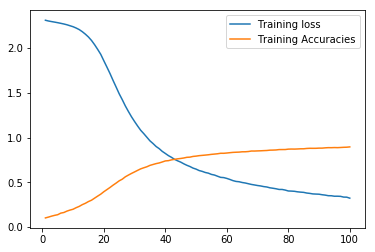

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs+1),[np.mean(teacher_train_history['avg_losses'][x]) for x in teacher_train_history['avg_losses']], label="Training loss")
plt.plot(range(1, epochs+1),[np.mean(teacher_train_history['avg_accuracies'][x]) for x in teacher_train_history['avg_accuracies']], label="Training Accuracies")
plt.legend()
plt.show()

In [15]:
for model in teachers:
    model.eval()

In [12]:
testloader = torch.utils.data.DataLoader(student_set, batch_size=1)
criterion = nn.NLLLoss()

In [13]:
counter = 0
total_loss = 0
acc_count = 0

pred_list = []
label_list = []

for images, labels in testloader:    
    
    label_list.append(labels)
    images, labels = images.to(device), labels.to(device)
    
    temp_pred = []
    with torch.no_grad():
         for model in teachers:                 
            counter += images.size(0)
            
            logps = model(images)
            preds = (torch.exp(logps)).argmax(dim=1)
            temp_pred.append(preds.cpu())
            
            loss = criterion(logps, labels)
            total_loss += loss.item()
            acc_count += (preds==labels).sum().item()
    
    pred_list.append(temp_pred)
    
preds_tensor = torch.cat([torch.stack(preds, dim=0) for preds in pred_list], dim=1)
preds_counts = torch.from_numpy(np.apply_along_axis(lambda x: np.bincount(x, minlength=10), axis=0, arr=preds_tensor.numpy()))

aggregate_preds = preds_counts.argmax(dim=0)
labels          = torch.cat(label_list, dim=0)

preds_tensor = 
aggregate_acc = (aggregate_preds == labels).float().mean().item()

print('\n')
print("Average Loss:", total_loss / counter)
print("Average Accuracy:", acc_count / counter)
print()
print("Aggregate Accuracy:", aggregate_acc)


/home/ayush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()




Average Loss: 0.3071698566626178
Average Accuracy: 0.9078844444444445

Aggregate Accuracy: 0.9403333067893982


In [16]:
len(pred_list)

9000

In [17]:
len(pred_list[0])

100

In [18]:
pred_list

[[tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([7]),
  tensor([

In [19]:
pred_list[0]

[tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tensor([7]),
 tenso

In [20]:
epsilon = 0.1

new_labels = []
for pred in pred_list:
    
    pred_count = np.bincount(pred, minlength=10)
    
    beta = 1/epsilon
    
    for i in range(len(pred_count)):
        pred_count[i] += np.random.laplace(0, beta, 1)
        
    new_labels.append(pred_count.argmax())

In [21]:
new_labels

[7,
 2,
 1,
 0,
 4,
 1,
 4,
 9,
 6,
 9,
 0,
 6,
 9,
 0,
 1,
 5,
 9,
 7,
 3,
 4,
 9,
 6,
 6,
 5,
 4,
 0,
 7,
 4,
 0,
 1,
 3,
 1,
 3,
 6,
 7,
 2,
 7,
 1,
 2,
 1,
 1,
 7,
 4,
 2,
 3,
 5,
 1,
 2,
 4,
 4,
 6,
 3,
 5,
 5,
 6,
 0,
 4,
 1,
 9,
 5,
 7,
 8,
 9,
 3,
 7,
 4,
 6,
 4,
 3,
 0,
 7,
 0,
 2,
 7,
 1,
 7,
 3,
 7,
 9,
 7,
 7,
 6,
 2,
 7,
 8,
 4,
 7,
 3,
 6,
 1,
 3,
 6,
 4,
 3,
 1,
 4,
 1,
 7,
 6,
 9,
 6,
 0,
 5,
 4,
 9,
 9,
 2,
 1,
 9,
 4,
 8,
 7,
 3,
 9,
 7,
 4,
 4,
 4,
 9,
 2,
 5,
 4,
 7,
 6,
 4,
 9,
 0,
 5,
 8,
 5,
 6,
 6,
 5,
 7,
 8,
 1,
 0,
 1,
 6,
 4,
 6,
 7,
 3,
 1,
 7,
 1,
 8,
 2,
 0,
 4,
 9,
 9,
 5,
 5,
 1,
 5,
 6,
 0,
 3,
 4,
 4,
 6,
 5,
 4,
 6,
 5,
 4,
 4,
 1,
 4,
 4,
 7,
 2,
 3,
 2,
 7,
 1,
 8,
 1,
 8,
 1,
 8,
 5,
 0,
 8,
 9,
 2,
 5,
 0,
 1,
 1,
 1,
 0,
 9,
 0,
 3,
 1,
 6,
 4,
 2,
 2,
 6,
 1,
 1,
 1,
 3,
 9,
 5,
 2,
 9,
 4,
 5,
 9,
 3,
 9,
 0,
 3,
 5,
 5,
 5,
 7,
 2,
 2,
 7,
 1,
 2,
 8,
 4,
 1,
 7,
 3,
 3,
 8,
 7,
 7,
 9,
 2,
 2,
 4,
 1,
 5,
 8,
 8,
 7,
 2,
 3,
 0,
 6,
 4,
 2,


In [22]:
actual_labels = testset.targets[:9000]
actual_labels

tensor([7, 2, 1,  ..., 6, 9, 0])

In [23]:
testset.targets[:9000] = torch.tensor(new_labels)

In [24]:
student_set = torch.utils.data.Subset(testset, list(range(int(len(testset) * 0.9))))

In [78]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
# student.to(torch.device("cpu"))
student = Model().to(device)
student = student.train()

epochs = 10
studentloader = torch.utils.data.DataLoader(student_set, batch_size=64, shuffle=False)
studentoptim = optim.SGD(student.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.NLLLoss()

In [79]:
student

Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [80]:
student_train_history = {'avg_losses':{}, 'avg_accuracies':{}}

for e in range(epochs):
    student.train()
    print("Epoch : ", (e+1), " ...")
    running_loss = 0
    accuracy = 0
    counter = 0
    
    for image, label in studentloader:
        studentoptim.zero_grad()
        
        image, label = image.to(device), label.to(device)
        counter += image.size(0)
        
        logps = student(image)
#         print(logps)
        preds = torch.argmax(torch.exp(logps), dim=1)
        
        loss = criterion(logps, label)
        loss.backward()
        studentoptim.step()
        
        running_loss += loss.item()
        accuracy += (preds==label).sum().item()
        
    student_train_history['avg_losses'][e] = running_loss/counter
    student_train_history['avg_accuracies'][e] = accuracy/counter
    print("Loss : ", running_loss/counter)
    print("Accuracy : ", accuracy/counter)

Epoch :  1  ...


/home/ayush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Loss :  0.03512296226289537
Accuracy :  0.1751111111111111
Epoch :  2  ...
Loss :  0.02431623887353473
Accuracy :  0.49033333333333334
Epoch :  3  ...
Loss :  0.013495224270555708
Accuracy :  0.7215555555555555
Epoch :  4  ...
Loss :  0.0099363787803385
Accuracy :  0.7955555555555556
Epoch :  5  ...
Loss :  0.0082465284731653
Accuracy :  0.8315555555555556
Epoch :  6  ...
Loss :  0.007319366860720846
Accuracy :  0.8534444444444444
Epoch :  7  ...
Loss :  0.006609157408277193
Accuracy :  0.8667777777777778
Epoch :  8  ...
Loss :  0.006274429752594895
Accuracy :  0.8715555555555555
Epoch :  9  ...
Loss :  0.005698138204713663
Accuracy :  0.8872222222222222
Epoch :  10  ...
Loss :  0.005405120056536462
Accuracy :  0.8947777777777778


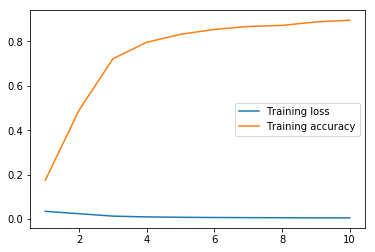

In [83]:
plt.plot(range(1, epochs+1), [student_train_history['avg_losses'][x] for x in range(epochs)], label="Training loss")
plt.plot(range(1, epochs+1), [student_train_history['avg_accuracies'][x] for x in range(epochs)], label="Training accuracy")
plt.legend()
plt.show()

In [91]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1024)

In [92]:
accuracy = 0
test_loss = 0
counter = 0
for image, label in test_loader:
    counter += image.size(0)
    image, label = image.to(device), label.to(device)
    
    with torch.no_grad():
        logps = student(image)
        preds = torch.argmax(torch.exp(logps), dim=1)
        loss = criterion(logps, label)
        
        test_loss += loss.item()
        accuracy += (preds==label).sum().item()
        
print("Loss : ", test_loss/counter)
print("Accuracy : ", accuracy/counter)

Loss :  0.00048012766242027283
Accuracy :  0.864


/home/ayush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [144]:
teacher_preds = torch.Tensor(pred_list).transpose(1,0)[:, :100]
indices = torch.Tensor(new_labels)[:100]
print(teacher_preds.shape)
print(indices.shape)
indices = indices.type(torch.uint8)

torch.Size([100, 100])
torch.Size([100])


In [145]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=teacher_preds, indices=indices, noise_eps = 0.1, moments = 20)
print(data_dep_eps)
print(data_ind_eps)

11.756462732485105
11.756462732485115
